In [1]:
# Install dependencies.
!rm -r sample_data
!pip install -qq --upgrade transformers compel accelerate git+https://github.com/huggingface/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.9 MB/s eta 0:00:00


In [3]:
# Set the details for your model here:
import torch

from diffusers import AutoencoderKL, StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

use_refiner = True

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    add_watermarker=False
)
_ = base.to("cuda")

if use_refiner:
  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      text_encoder_2=base.text_encoder_2,
      torch_dtype=torch.float16,
      variant="fp16",
      use_safetensors=True,
      add_watermarker=False
  )
  _ = refiner.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
torch.cuda.empty_cache()

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', masterpiece, 8 k']
Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', masterpiece, 8 k']


  0%|          | 0/23 [00:00<?, ?it/s]

tensor(37.7500, device='cuda:0', dtype=torch.float16) tensor(-37.7500, device='cuda:0', dtype=torch.float16) tensor(-0.0968, device='cuda:0', dtype=torch.float16)
tensor(32.0625, device='cuda:0', dtype=torch.float16) tensor(-32.0625, device='cuda:0', dtype=torch.float16) tensor(-0.1434, device='cuda:0', dtype=torch.float16)
tensor(27.2812, device='cuda:0', dtype=torch.float16) tensor(-27.4062, device='cuda:0', dtype=torch.float16) tensor(-0.1788, device='cuda:0', dtype=torch.float16)
tensor(23.3281, device='cuda:0', dtype=torch.float16) tensor(-23.6094, device='cuda:0', dtype=torch.float16) tensor(-0.2046, device='cuda:0', dtype=torch.float16)
tensor(19.8906, device='cuda:0', dtype=torch.float16) tensor(-20.4219, device='cuda:0', dtype=torch.float16) tensor(-0.2554, device='cuda:0', dtype=torch.float16)
tensor(17.2344, device='cuda:0', dtype=torch.float16) tensor(-17.8281, device='cuda:0', dtype=torch.float16) tensor(-0.2600, device='cuda:0', dtype=torch.float16)
tensor(15.0625, device

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', masterpiece, 8 k']


tensor(3.9922, device='cuda:0', dtype=torch.float16) tensor(-3.8047, device='cuda:0', dtype=torch.float16) tensor(-0.2288, device='cuda:0', dtype=torch.float16)


  0%|          | 0/7 [00:00<?, ?it/s]

tensor(3.7520, device='cuda:0', dtype=torch.float16) tensor(-3.6035, device='cuda:0', dtype=torch.float16) tensor(-0.2296, device='cuda:0', dtype=torch.float16)
tensor(3.5742, device='cuda:0', dtype=torch.float16) tensor(-3.4102, device='cuda:0', dtype=torch.float16) tensor(-0.2305, device='cuda:0', dtype=torch.float16)
tensor(3.4023, device='cuda:0', dtype=torch.float16) tensor(-3.2676, device='cuda:0', dtype=torch.float16) tensor(-0.2313, device='cuda:0', dtype=torch.float16)
tensor(3.2266, device='cuda:0', dtype=torch.float16) tensor(-3.1484, device='cuda:0', dtype=torch.float16) tensor(-0.2321, device='cuda:0', dtype=torch.float16)
tensor(3.1016, device='cuda:0', dtype=torch.float16) tensor(-3.0762, device='cuda:0', dtype=torch.float16) tensor(-0.2329, device='cuda:0', dtype=torch.float16)
tensor(2.9609, device='cuda:0', dtype=torch.float16) tensor(-3.0293, device='cuda:0', dtype=torch.float16) tensor(-0.2338, device='cuda:0', dtype=torch.float16)
tensor(2.9453, device='cuda:0', dt

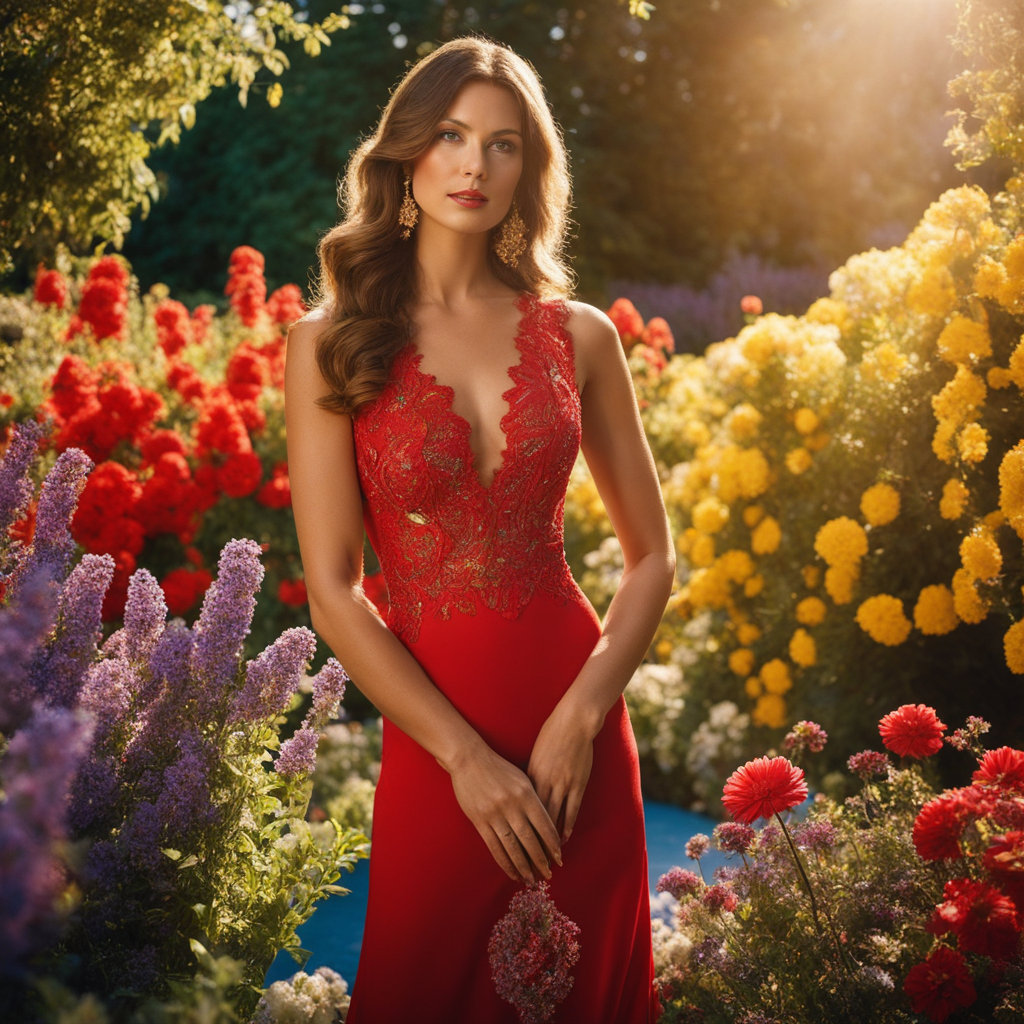

In [4]:
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt="Photograph of woman in red dress in a luxury garden surrounded with blue, yellow, purple and flowers in many colors, high class, award-winning photography, Portra 400, full format"
prompt += "blue sky, intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

num_inference_steps = 30
guidance_scale = 10

def soft_clamp_tensor(input_tensor, threshold=3.5, boundary=4):
    if max(abs(input_tensor.max()), abs(input_tensor.min())) < 4:
        return input_tensor
    channel_dim = 1

    max_vals = input_tensor.max(channel_dim, keepdim=True)[0]
    max_replace = ((input_tensor - threshold) / (max_vals - threshold)) * (boundary - threshold) + threshold
    over_mask = (input_tensor > threshold)

    min_vals = input_tensor.min(channel_dim, keepdim=True)[0]
    min_replace = ((input_tensor + threshold) / (min_vals + threshold)) * (-boundary + threshold) - threshold
    under_mask = (input_tensor < -threshold)

    return torch.where(over_mask, max_replace, torch.where(under_mask, min_replace, input_tensor))

def callback(pipe, step_index, timestep, cbk):
    print("timestep:", timestep.item(), "max:", cbk["latents"].max().item(), "min:", cbk["latents"].min().item(), "mean:", cbk["latents"].mean().item())
    return cbk

base_seed = 2222
base_generator = torch.Generator()
base_generator.manual_seed(base_seed)
if use_refiner:
  refiner_generator = torch.Generator()
  refiner_generator.manual_seed(base_seed ^ 0xffffffff)

image = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale = guidance_scale, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=base_generator, denoising_end=0.8 if use_refiner else 1.0, output_type="latent" if use_refiner else "pil").images
if use_refiner:
  image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=refiner_generator, denoising_start=0.8, image=image).images
display(image[0])

In [ ]:
"""
import os
import time
import diffusers
from diffusers import PNDMScheduler

prompt="Photograph of a beautiful woman standing in a lush garden"
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

for use_karras_sigmas in [True]:
    for scheduler in base.scheduler.compatibles:
        scheduler_name = scheduler.__name__
        if scheduler_name in ("PNDMScheduler", "KDPM2AncestralDiscreteScheduler"):
            ske = scheduler.from_config(base.scheduler.config, use_karras_sigmas=use_karras_sigmas)
            base.scheduler = ske
            for num_inference_steps in range(5, 36, 5):
                print("Generating with", scheduler_name)
                start_time = time.time()
                latents = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_end=0.8, output_type="latent").images
                image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_start=0.8, image=latents).images[0]
                folder_path = f"/content/drive/MyDrive/schedulers/{'k' if use_karras_sigmas else ''}{num_inference_steps}"
                os.makedirs(folder_path, exist_ok=True)
                image.save(f"{folder_path}/{str(round(float(time.time()-start_time),2)).replace('.', ',')}_{scheduler_name}.png")
"""

In [ ]:
!zip -r png_files.zip *.png
!rm -r *.png